In [1]:
import os, sys, shutil, time, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import urllib.request

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import Sampler

In [2]:
 #Step 1: sort images by aspect ratio
def sort_ar(valdir):
    idx2ar_file = 'sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Sorting images by Aspect Ratio. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir)
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    return sorted_idxar

# Step 2: chunk images by batch size. This way we can crop each image to the batch aspect ratio mean 
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

# Step 3: map image index to batch aspect ratio mean so our transform function knows where to crop
def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs:
            idx2ar[idx] = mean
    return idx2ar



In [3]:
import re
import shutil
from pathlib import Path
from typing import Iterable

valdir = "imagenet-sample-images/"


def organize_images_by_class(
    base_dir: str | Path,
    exts: Iterable[str] = (".jpg", ".jpeg", ".png", ".bmp", ".tiff"),
    dry_run: bool = False,
) -> None:
    """
    Read images from base_dir, infer class name from filename, create a class
    subfolder, and move the file there.

    Expected filename format (like ImageNet): <prefix>_<class_name>.<ext>
    e.g. 'n01440764_tench.JPEG', 'n01484850_great_white_shark.JPEG'

    Args:
        base_dir: directory containing the flat list of images.
        exts: allowed image extensions (case-insensitive).
        dry_run: if True, prints what would happen without moving files.
    """
    base = Path(base_dir)
    if not base.is_dir():
        raise NotADirectoryError(f"{base} is not a directory")

    # capture everything after the first underscore up to the extension
    name_pat = re.compile(r"^[^_]+_(?P<cls>[^.]+)\.", flags=re.IGNORECASE)

    moved, skipped = 0, 0
    for p in base.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in exts:
            skipped += 1
            continue

        m = name_pat.match(p.name)
        if not m:
            skipped += 1
            continue

        cls = m.group("cls")                 # e.g. "great_white_shark"
        dest_dir = base / cls
        dest_dir.mkdir(exist_ok=True)

        dest = dest_dir / p.name
        # Avoid clobbering if a file with same name already exists
        if dest.exists():
            i = 1
            while (dest_dir / f"{p.stem}_{i}{p.suffix}").exists():
                i += 1
            dest = dest_dir / f"{p.stem}_{i}{p.suffix}"

        if dry_run:
            print(f"[DRY RUN] move {p} -> {dest}")
        else:
            shutil.move(str(p), str(dest))
        moved += 1

    print(f"Done. Moved {moved} file(s), skipped {skipped}.")

# Example:
#organize_images_by_class(valdir)


In [4]:
valdir = "imagenet-sample-images/"
idx_ar = sort_ar(valdir)


In [5]:
idx_ar

[(0, 1.33333)]

In [6]:


print('First five:', idx_ar[:5])
print('Last five:', idx_ar[-5:])



First five: [(0, 1.33333)]
Last five: [(0, 1.33333)]


In [23]:
class RectangularCropTfm(object):
    def __init__(self, idx2ar, target_size):
        self.idx2ar, self.target_size = idx2ar, target_size
    def __call__(self, img, idx):
        target_ar = self.idx2ar[0]
        if target_ar < 1: 
            w = int(self.target_size/target_ar)
            size = (w//8*8, self.target_size)
        else: 
            h = int(self.target_size*target_ar)
            size = (self.target_size, h//8*8)
        return transforms.functional.center_crop(img, size)


class ValDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            for tfm in self.transform:
                if isinstance(tfm, RectangularCropTfm): sample = tfm(sample, index)
                else: sample = tfm(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


In [24]:
val_bs = 128
idx2ar = map_idx2ar(idx_ar, val_bs)
target_size = 128


In [25]:
# Rect
val_ar_tfms = [transforms.Resize(int(target_size*1.14)), RectangularCropTfm(idx2ar, target_size)]
val_dataset_ar = ValDataset(valdir, val_ar_tfms)

# No transforms
orig_dataset = datasets.ImageFolder(valdir, transforms.Resize(target_size))

val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)]
val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))

min_scale = 0.5
trn_tfms = [
        transforms.RandomResizedCrop(target_size, scale=(min_scale, 1.0)),
        transforms.RandomHorizontalFlip(),
    ]
tta_aug_dataset = datasets.ImageFolder(valdir, transforms.Compose(trn_tfms))



In [26]:
orig_dataset[2]

(<PIL.Image.Image image mode=RGB size=170x128>, 2)

In [27]:
def show_validation_image(sorted_index, figsize=(10,10), ind=0):
    index, aspect_ratio = idx_ar[sorted_index]
    print('Aspect ratio:', aspect_ratio)
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=figsize)
    f.tight_layout(h_pad=6.0)
    fontsize = 15
    ax1[0].imshow(orig_dataset[ind][0])
    ax1[0].set_title('Center Crop Image', fontsize=fontsize)
    ax1[1].imshow(val_dataset_ar[ind][0])
    ax1[1].set_title('FastAi Rectangular Crop', fontsize=fontsize)
    ax2[0].imshow(val_dataset[ind][0])
    ax2[0].set_title('Imagenet Center Crop', fontsize=fontsize)
    ax2[1].imshow(tta_aug_dataset[ind][0])
    ax2[1].set_title('Test Time Augmentation 1', fontsize=fontsize)
    ax3[0].imshow(tta_aug_dataset[ind][0])
    ax3[0].set_title('Test Time Augmentation 2', fontsize=fontsize)
    ax3[1].imshow(tta_aug_dataset[ind][0])
    ax3[1].set_title('Test Time Augmentation 3', fontsize=fontsize)

Aspect ratio: 1.33333


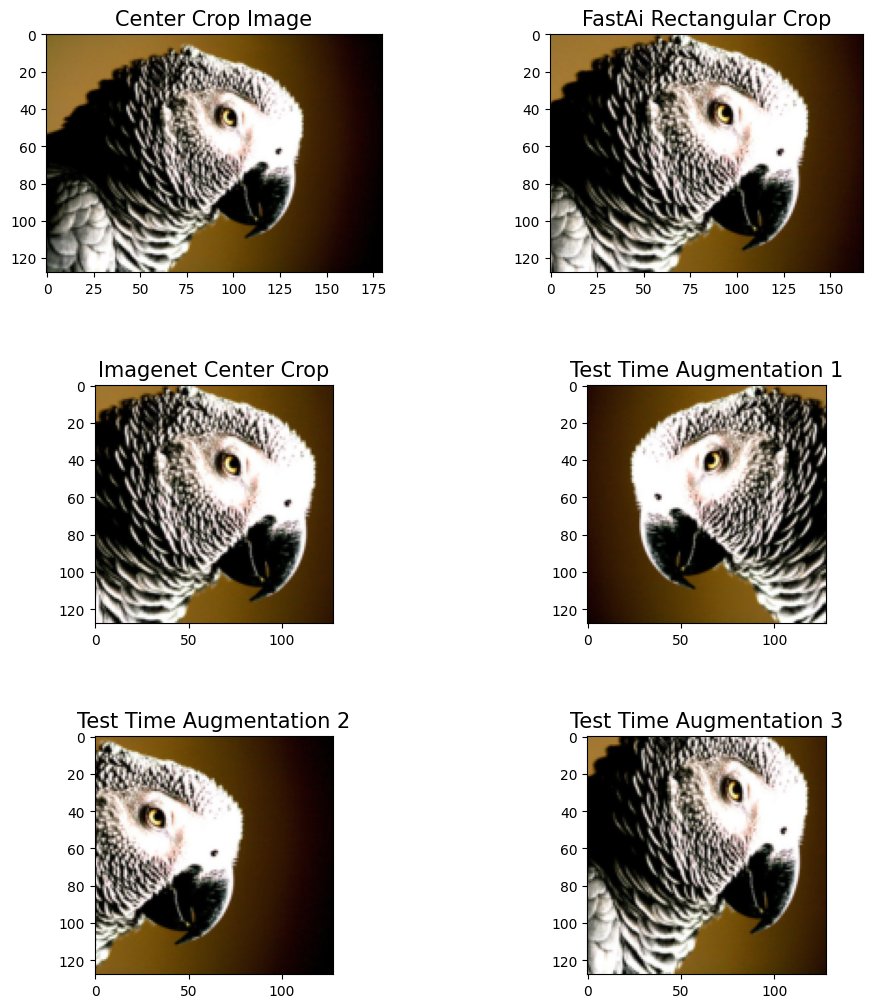

In [29]:
show_validation_image(0, figsize=(10,10), ind=5)